In [1]:
# From: https://www.kaggle.com/c/dog-breed-identification/data
# Author: Morpheus Hsieh (morpheus.hsieh@gmail.com)

from __future__ import print_function, division

import os, sys
import copy
import json
import numpy as np
import pandas as pd
import time
from datetime import datetime
from os import listdir
from os.path import join, exists
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


In [2]:
Params = {
    'DataPath'    : r'D:\GitWork\dog_breed\data',
    'OutPath'     : r'D:\GitWork\dog_breed\output',
    'ProcPath'    : r'D:\GitWork\dog_breed\processed',
    'PreTrainPath': r'D:\GitWork\dog_breed\pretrained',
    'PreTrainFile': 'resnet50_20200923-1604_acc79.pth',
    'LoadPreModel': True,
    'TestPath'    : r'D:\GitWork\dog_breed\data\test',
    'TrainPath'   : r'D:\GitWork\dog_breed\data\train',
    'CsvLabel'    : 'labels.csv',
    'BatchSize'   : 16,
    'FracForTrain': 0.8
}


def prettyDict(dic, indent=2):
    array = []
    key_maxlen = 0
    item_cnt = 0
    item_size = len(dic)
    split_str = ': '
    
    for key, val in dic.items():
        if key_maxlen < len(str(key)): 
            key_maxlen = len(str(key))
        
        tmpstr = ''
        tmpstr += f"'{key}'" if isinstance(key, str) else f"{key}"
        tmpstr += split_str
        tmpstr += f"'{val}'" if isinstance(val, str) else f"{val}"

        item_cnt += 1
        if item_cnt < item_size: tmpstr += ','
        array.append(tmpstr)
    
    for i in range(len(array)):
        inStr = array[i]
        ary = inStr.split(split_str)
        key = ary[0].ljust(key_maxlen+2)
        val = ary[1]
        array[i] = (' '*indent) + key + ': ' + val
        
    outstr = '{\n' + '\n'.join(array) + '\n}'
    return outstr

outstr = prettyDict(Params)
print('Parameters:')
print(outstr)

Parameters:
{
  'DataPath'    : 'D:\GitWork\dog_breed\data',
  'OutPath'     : 'D:\GitWork\dog_breed\output',
  'ProcPath'    : 'D:\GitWork\dog_breed\processed',
  'PreTrainPath': 'D:\GitWork\dog_breed\pretrained',
  'PreTrainFile': 'resnet50_20200923-1604_acc79.pth',
  'LoadPreModel': True,
  'TestPath'    : 'D:\GitWork\dog_breed\data\test',
  'TrainPath'   : 'D:\GitWork\dog_breed\data\train',
  'CsvLabel'    : 'labels.csv',
  'BatchSize'   : 16,
  'FracForTrain': 0.8
}


In [3]:
# Read breed information from csv
DataPath = Params.get('DataPath')
csv_labels = Params.get('CsvLabel')
f_abspath = join(DataPath, csv_labels)

df_labels = pd.read_csv(f_abspath)

print(df_labels.info())
print()
print(df_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
# Count all breeds
def countBreeds(df):
    df1 = df_labels.groupby("breed")["id"].count().reset_index(name="count")
    df1 = df1.sort_values(by='count', ascending=False).reset_index(drop=True)
    df1.insert(0, 'breed_id', df1.index)
    return df1

df_breeds = countBreeds(df_labels)
print(df_breeds.info())
print()
print(df_breeds.head())

NumClasses = int(df_breeds.shape[0])
print('\nNum classes:', NumClasses)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   breed_id  120 non-null    int64 
 1   breed     120 non-null    object
 2   count     120 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ KB
None

   breed_id                 breed  count
0         0    scottish_deerhound    126
1         1           maltese_dog    117
2         2          afghan_hound    116
3         3           entlebucher    115
4         4  bernese_mountain_dog    114

Num classes: 120


In [5]:
# Process labels

dict_bid_fw = dict(df_breeds[['breed', 'breed_id']].values)
# print(dict_bid_fw)

dict_bid_bw = dict(df_breeds[['breed_id', 'breed']].values)
# print(dict_bid_bw)

# Build processed labels file
df_data = pd.DataFrame(columns=['image', 'breed_id'])
df_data['breed_id'] = df_labels.breed.map(dict_bid_fw)

TranPath = Params['TrainPath']

df_data['image'] = df_labels.apply (
    lambda row: join(TranPath, row['id']+'.jpg') \
    if exists(join(TranPath, row['id']+'.jpg')) else None, 
    axis=1
)

print(df_data.info())
print(df_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     10222 non-null  object
 1   breed_id  10222 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.8+ KB
None
                                               image  breed_id
0  D:\GitWork\dog_breed\data\train\000bec180eb18c...        42
1  D:\GitWork\dog_breed\data\train\001513dfcb2ffa...        72
2  D:\GitWork\dog_breed\data\train\001cdf01b096e0...        94
3  D:\GitWork\dog_breed\data\train\00214f311d5d22...        50
4  D:\GitWork\dog_breed\data\train\0021f9ceb3235e...       115


In [6]:
# Create dataset

# Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    )
])

class myDataset(Dataset):

    def __init__(self, df, phase='train', frac=0.8, transform=None):
        
        num_rows = df.shape[0]
        train_len = int(float(frac) * float(num_rows))
        valid_len = num_rows - train_len
        
        data = df.head(train_len) if phase=='train' else df.tail(valid_len)
        self.images = data['image'].tolist()
        self.labels = data['breed_id'].tolist()

        self.transform = transform
        self.len = len(self.images)

    def __getitem__(self, index):
        f_abspath = self.images[index]
        img_pil = Image.open(f_abspath)

        if self.transform is not None:
            img = self.transform(img_pil)

        lbl = int(self.labels[index])
        iid = os.path.split(f_abspath)[1].replace('.jpg', '')
        
        return [img, lbl, iid]

    def __len__(self):
        return self.len
    

frac = Params['FracForTrain']

phases = ['train', 'valid']
dataSet = { 
    x: myDataset(df_data, phase=x, frac=frac, transform=transform) for x in phases 
}

BatchSize = Params['BatchSize']
dataLoader = {
    x: DataLoader(dataSet[x], batch_size=BatchSize, shuffle=True) for x in phases
}

dataSizes = { x: len(dataSet[x]) for x in phases }
print('DataSet size:', dataSizes)

trainLoader = dataLoader['train']
imgs, lbls, iids = next(iter(trainLoader))
print('\nImage shape:', imgs.size())
print('Label shape:', lbls.size())

print('\nImage iid:')
id_list = [''.join(iid) for iid in iids]
print('  '+'\n  '.join(id_list))

img = imgs[0]
print('\nImage shape:', img.shape)
print(); print(img)

print('\nLabels:', lbls[0])

DataSet size: {'train': 8177, 'valid': 2045}

Image shape: torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16])

Image iid:
  9e14a1584d8ee8447ff5f71896fca8a8
  0c68a578981993b919e89c611f04a97f
  caf49640a8436f3ed39c56b1c5e447db
  776a702e80fc75c7969198ede3ee0aad
  757556f1f0520020f09adea9512078a7
  87e198d332493454d0c5645945050f8e
  0a7899ed6a15f4af8f28e01c9c44dcfe
  8e45f42d744b4a48ffe7ea8520a96f65
  1935abc5226ad6d2cdcaed722d685623
  b51261d75a427148d502ecd9108312db
  9529b8093aeca32d8828004347667c44
  b6fe6d1a08a8766f5db00a06e635bbc2
  07096719a671e1737b829bd1a88f1dbf
  373cc94717c239adb17c67421fa6d73a
  5783b64ce4c041c603e436f27e9c7e4c
  670b1a17892480ae3cbc151f3030f14f

Image shape: torch.Size([3, 224, 224])

tensor([[[-1.5528, -1.4500, -1.5185,  ..., -1.2103, -1.2959, -1.3302],
         [-1.6384, -1.5185, -1.4672,  ..., -1.3302, -1.3644, -1.3987],
         [-1.6213, -1.5014, -1.3987,  ..., -1.3987, -1.4158, -1.4158],
         ...,
         [-1.4500, -1.3473, -1.1247,  ...

In [7]:
# Use GPU for train
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [8]:
# Build Model
def buildModel(use_gpu, numClasses, preTrainModel=None):
    model = models.resnet50(pretrained=True)

    # freeze all model parameters
    for param in model.parameters():
        model.requires_grad = False

    # new final layer with 16 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, numClasses)
    
    if preTrainModel is not None:
        model.load_state_dict(preTrainModel)
        
    if use_gpu: 
        model = model.cuda()
        
    return model


pretrain_model = None

load_premodel = Params['LoadPreModel']
if load_premodel > 0:
    path  = Params['PreTrainPath']
    fname = Params['PreTrainFile']
    pretrain_model = torch.load(join(path, fname))

model = buildModel(use_gpu, NumClasses, preTrainModel=pretrain_model)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

layer4.2.bn1.running_mean 	 torch.Size([512])
layer4.2.bn1.running_var 	 torch.Size([512])
layer4.2.bn1.num_batches_tracked 	 torch.Size([])
layer4.2.conv2.weight 	 torch.Size([512, 512, 3, 3])
layer4.2.bn2.weight 	 torch.Size([512])
layer4.2.bn2.bias 	 torch.Size([512])
layer4.2.bn2.running_mean 	 torch.Size([512])
layer4.2.bn2.running_var 	 torch.Size([512])
layer4.2.bn2.num_batches_tracked 	 torch.Size([])
layer4.2.conv3.weight 	 torch.Size([2048, 512, 1, 1])
layer4.2.bn3.weight 	 torch.Size([2048])
layer4.2.bn3.bias 	 torch.Size([2048])
layer4.2.bn3.running_mean 	 torch.Size([2048])
layer4.2.bn3.running_var 	 torch.Size([2048])
layer4.2.bn3.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([120, 2048])
fc.bias 	 torch.Size([120])


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'initial_lr': 0.001, 'params': [2990911745464, 2990911744424]}]


In [11]:
# Train and validate Model

def train_model(loader, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history  = [] 
    
    dataset_sizes = {
        'train': len(loader['train'].dataset),
        'valid': len(loader['valid'].dataset)
    }

    for epoch in range(num_epochs):
        
        for phase in ['train', 'valid']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels, iids in loader[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistic
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            data_size = dataset_sizes[phase]
            
            if phase == 'train':
                train_epoch_loss = running_loss / data_size
                train_epoch_acc  = running_corrects / data_size
            else:
                valid_epoch_loss = running_loss / data_size
                valid_epoch_acc  = running_corrects / data_size

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        history.append({
            'train_acc' : train_epoch_acc.item(), 
            'train_loss': train_epoch_loss, 
            'valid_acc' : valid_epoch_acc.item(),
            'valid_loss': valid_epoch_loss
        })
        
        print('Epoch [{:3d}/{:3d}] train loss: {:.4f} acc: {:.4f}' 
              '\n                valid loss: {:.4f} acc: {:.4f}'.format(
                  epoch, num_epochs - 1,
                  train_epoch_loss, train_epoch_acc, 
                  valid_epoch_loss, valid_epoch_acc))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, best_acc, history

In [12]:
NumEpochs = 2
start_time = time.time()

best_model, best_acc, history = train_model(
    dataLoader, model, criterion, optimizer, exp_lr_scheduler, NumEpochs
)
    
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [  0/  1] train loss: 0.0582 acc: 0.8145
                valid loss: 0.0496 acc: 0.7961
Epoch [  1/  1] train loss: 0.0530 acc: 0.8201
                valid loss: 0.0468 acc: 0.8039
Best val Acc: 0.803912
Training time:   5.550044 minutes


[{"train_acc": 0.814479649066925, "train_loss": 0.0582491326072593, "valid_acc": 0.7960880398750305, "valid_loss": 0.04964077915713956}, {"train_acc": 0.8201051354408264, "train_loss": 0.052958092071964266, "valid_acc": 0.8039119839668274, "valid_loss": 0.046761533246355125}]


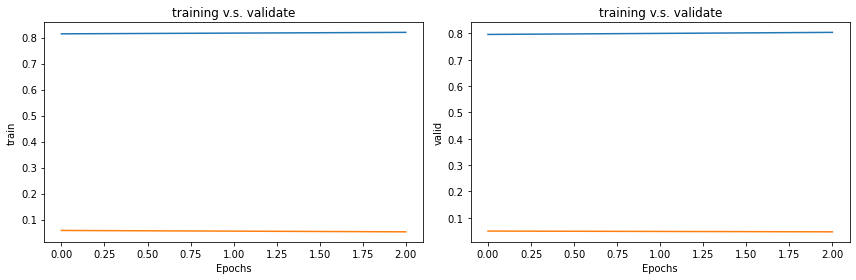

In [18]:
import matplotlib.pyplot as plt

print(json.dumps(history))

train_acc  = []
train_loss = []
valid_acc  = []
valid_loss = []

for i in range(len(history)):
    train_acc.append(history[i]['train_acc'])
    train_loss.append(history[i]['train_loss'])

    valid_acc.append(history[i]['valid_acc'])
    valid_loss.append(history[i]['valid_loss'])
        
def plot_lines(y1, y2, label=None, ax=None):
    epochs = len(history)
    x = np.linspace(0, epochs, num=epochs)
    ax.plot(x, y1, label="train")
    ax.plot(x, y2, label="valid")
    ax.set_title('training v.s. validate')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    
    
# 1. Plot in same line, this would work
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1,2,1)
plot_lines(train_acc, train_loss, 'train', ax1)

ax2 = fig.add_subplot(1,2,2)
plot_lines(valid_acc, valid_loss, 'valid', ax2)

fig.tight_layout()
plt.show()

In [14]:
currDT = datetime.now()
currStr = currDT.strftime("%Y%m%d-%H%M")

acc_str = int(best_acc * 100)
fname_best_model = 'resnet50_{}_acc{}.pth'.format(currStr, acc_str)

best_model_wts = best_model.state_dict()

OutPath = Params['OutPath']
best_model_out = join(OutPath, fname_best_model)

torch.save(best_model_wts, best_model_out)

In [15]:
# Save parameters to json file

fname = 'Params_{}.json'.format(currStr)
f_abspath = join(OutPath, fname)

json_str = json.dumps(Params, indent=4)
print(json_str)

with open(f_abspath, 'w') as fout:
    fout.write(json_str)

{
    "DataPath": "D:\\GitWork\\dog_breed\\data",
    "OutPath": "D:\\GitWork\\dog_breed\\output",
    "ProcPath": "D:\\GitWork\\dog_breed\\processed",
    "PreTrainPath": "D:\\GitWork\\dog_breed\\pretrained",
    "PreTrainFile": "resnet50_20200923-1604_acc79.pth",
    "LoadPreModel": true,
    "TestPath": "D:\\GitWork\\dog_breed\\data\\test",
    "TrainPath": "D:\\GitWork\\dog_breed\\data\\train",
    "CsvLabel": "labels.csv",
    "BatchSize": 16,
    "FracForTrain": 0.8
}


In [16]:
# Save breed dict to json file
fname = 'BreedDict_{}.json'.format(currStr)
f_abspath = join(OutPath, fname)

json_str = json.dumps(dict_bid_fw, indent=4)
print(json_str)

with open(f_abspath, 'w') as fout:
    fout.write(json_str)

{
    "scottish_deerhound": 0,
    "maltese_dog": 1,
    "afghan_hound": 2,
    "entlebucher": 3,
    "bernese_mountain_dog": 4,
    "shih-tzu": 5,
    "great_pyrenees": 6,
    "pomeranian": 7,
    "basenji": 8,
    "samoyed": 9,
    "airedale": 10,
    "tibetan_terrier": 11,
    "leonberg": 12,
    "cairn": 13,
    "beagle": 14,
    "japanese_spaniel": 15,
    "australian_terrier": 16,
    "blenheim_spaniel": 17,
    "miniature_pinscher": 18,
    "irish_wolfhound": 19,
    "lakeland_terrier": 20,
    "saluki": 21,
    "papillon": 22,
    "whippet": 23,
    "siberian_husky": 24,
    "norwegian_elkhound": 25,
    "pug": 26,
    "chow": 27,
    "italian_greyhound": 28,
    "pembroke": 29,
    "ibizan_hound": 30,
    "border_terrier": 31,
    "newfoundland": 32,
    "lhasa": 33,
    "silky_terrier": 34,
    "bedlington_terrier": 35,
    "dandie_dinmont": 36,
    "irish_setter": 37,
    "sealyham_terrier": 38,
    "rhodesian_ridgeback": 39,
    "old_english_sheepdog": 40,
    "collie": 41,